## Сборный проект

**Описание проекта** 

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

In [1]:
!pip install torch torchvision numpy

## 1. Исследовательский анализ данных

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from PIL import Image
import cv2

from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout, BatchNormalization
from keras.activations import relu, elu, linear, sigmoid


In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
labels = pd.read_csv('D:/Practicum/Project_5/to_upload/train_dataset.csv', sep=',')

In [5]:
def df_show(df):
    print(df.head(10))
    print(df.info())
    print(df.describe())
    print('Дубликаты: ',df.duplicated().sum())

In [6]:
df_show(labels)

                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                                                 query_text  
0  A young child is wearing blue goggles and sitting in a float in a pool .  
1  A young child is wearing blue goggles and sitting in a float in a pool .  
2  A young child is wearing blue goggles and sitting in a float in a pool .  
3  A young child

**Результат загрузки train_dataset.csv** 

Загружена информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>. - Данные соответствуют описанию.

Всего кол-во строк 5822, из них 1000 изображений уникальные, 977 уникальных описаний.

Дубликатов нет.

**ExpertAnnotations**

In [7]:
expert = pd.read_csv('D:/Practicum/Project_5/to_upload/ExpertAnnotations.tsv', sep='\t', header=None)

In [8]:
df_show(expert)

                           0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2  1  1  1
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2  1  1  1
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  1  1  2
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2  1  1  1
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2  2  2  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       

**Результат загрузки ExpertAnnotations** 

Экспертные оценки также содержат 5822 записи. Данные соответствуют описанию в задании.

Нет дубликатов и нет пропусков.

**Агрегируем оценки экспертов в одну по принципу голосования большинства.**

In [9]:
expert.columns = ['image', 'query_id', '1', '2', '3']

In [10]:
def vote(row):
    votes = [row['1'], row['2'], row['3']]
    vote_count = Counter(votes)
    max_votes = max(vote_count.values())
    lst = [i for i in vote_count.keys() if vote_count[i]==max_votes]
    if len(lst) == 1:
        return lst[0]
    else:
        return

In [11]:
expert['sum_vote'] = expert.apply(vote, axis=1)

In [12]:
expert.sample(10)

image                     query_id  1  2  3  \
4287  3490736665_38710f4b91.jpg  2924259848_effb4dcb82.jpg#2  1  1  1   
5796    96420612_feb18fc6c6.jpg  3287549827_04dec6fb6e.jpg#2  1  2  2   
5017   373394550_1b2296b8c4.jpg  3530843182_35af2c821c.jpg#2  1  1  1   
4549  3562050678_4196a7fff3.jpg    53043785_c468d6f931.jpg#2  2  2  2   
783   2103568100_5d018c495b.jpg  2696866120_254a0345bc.jpg#2  2  2  2   
2543  2926595608_69b22be8d4.jpg  2926595608_69b22be8d4.jpg#2  4  4  4   
4562  3564543247_05cdbc31cf.jpg  3430607596_7e4f74e3ff.jpg#2  3  3  3   
5496    53043785_c468d6f931.jpg   327415627_6313d32a64.jpg#2  1  1  1   
3449  3223055565_68973f5d20.jpg  3482974845_db4f16befa.jpg#2  1  2  2   
5767   909191414_1cf5d85821.jpg   166507476_9be5b9852a.jpg#2  1  1  1   

      sum_vote  
4287       1.0  
5796       2.0  
5017       1.0  
4549       2.0  
783        2.0  
2543       4.0  
4562       3.0  
5496       1.0  
3449       2.0  
5767       1.0

In [13]:
expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5822 non-null   object 
 1   query_id  5822 non-null   object 
 2   1         5822 non-null   int64  
 3   2         5822 non-null   int64  
 4   3         5822 non-null   int64  
 5   sum_vote  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст исключим из датасета.

In [14]:
expert.dropna(axis = 'index', subset = ['sum_vote'], inplace = True)

In [15]:
expert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5696 non-null   object 
 1   query_id  5696 non-null   object 
 2   1         5696 non-null   int64  
 3   2         5696 non-null   int64  
 4   3         5696 non-null   int64  
 5   sum_vote  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 311.5+ KB


In [16]:
expert['sum_vote'].value_counts()

sum_vote
1.0    3327
2.0    1566
3.0     492
4.0     311
Name: count, dtype: int64

Приведем оценки экспертов к диапазону от 0 до 1.

In [17]:
expert['prob_vote'] = (expert['sum_vote'] - 1)/3

In [18]:
expert['prob_vote'].value_counts()

prob_vote
0.000000    3327
0.333333    1566
0.666667     492
1.000000     311
Name: count, dtype: int64

**CrowdAnnotations**

In [19]:
crowd = pd.read_csv('D:/Practicum/Project_5/to_upload/CrowdAnnotations.tsv', sep='\t', header=None)

In [20]:
df_show(crowd)

                           0                            1         2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.000000  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.000000  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.000000  0  3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.000000  0  3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.000000  0  3
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2  0.000000  0  3
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2  0.000000  0  3
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2  0.333333  1  2
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2  0.000000  0  3
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2  0.000000  0  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0  

In [21]:
crowd.columns = ['image', 'query_id', 'crowd_rate', 'crowd_count_pos', 'crowd_count_neg']

In [22]:
crowd.sample(1)

image                     query_id  crowd_rate  \
45452  533979933_a95b03323b.jpg  3673165148_67f217064f.jpg#2         0.0   

       crowd_count_pos  crowd_count_neg  
45452                0                3

**Результат загрузки CrowdAnnotations** 

Краудсорсинговые оценки содержат большое кол-во записей - 47830. Данные соответствуют описанию в задании.

Нет дубликатов и нет пропусков.

**Объединим оценки и исходный датасет**

Для объединения с экспертными оценками используем inner соединение.

In [23]:
marks = pd.merge(labels, expert, on = ['image', 'query_id'], how='inner')

In [24]:
marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5696 non-null   object 
 1   query_id    5696 non-null   object 
 2   query_text  5696 non-null   object 
 3   1           5696 non-null   int64  
 4   2           5696 non-null   int64  
 5   3           5696 non-null   int64  
 6   sum_vote    5696 non-null   float64
 7   prob_vote   5696 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 356.1+ KB


Для объединения с краудсорсинговыми оценками используем соединение left

In [25]:
marks = pd.merge(marks, crowd, on = ['image', 'query_id'], how='left')

In [26]:
marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5696 non-null   object 
 1   query_id         5696 non-null   object 
 2   query_text       5696 non-null   object 
 3   1                5696 non-null   int64  
 4   2                5696 non-null   int64  
 5   3                5696 non-null   int64  
 6   sum_vote         5696 non-null   float64
 7   prob_vote        5696 non-null   float64
 8   crowd_rate       2258 non-null   float64
 9   crowd_count_pos  2258 non-null   float64
 10  crowd_count_neg  2258 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 489.6+ KB


In [27]:
marks.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                                                 query_text  \
0  A young child is wearing blue goggles and sitting in a float in a pool .   
1  A young child is wearing blue goggles and sitting in a float in a pool .   
2  A young child is wearing blue goggles and sitting in a float in a pool .   
3  A young child is wearing blue goggles and sitting in a float in a pool .   
4  A young child is wearing blue goggles and sitting in a float in a pool .   

   1  2  3  sum_vote  prob_vote  crowd_rate  crowd_count_pos  crowd_count_neg  
0  1  1  1       1.0   0.000000         0.0              0.0              3.0  
1  1  1  1       1.0   0.000000         NaN              NaN              NaN  
2  1  2  2       2.0   0.333333         0.0              0.0              3.0  
3  4  4  4       4.0   1.000000         1.0              3.0              0.0  
4  1  1  1       1.0   0.000000         NaN              NaN              NaN

In [28]:
marks['crowd_rate'].isna()

0       False
1        True
2       False
3       False
4        True
        ...  
5691    False
5692     True
5693     True
5694    False
5695     True
Name: crowd_rate, Length: 5696, dtype: bool

In [29]:
def prob_vote(row):
    if pd.isna(row['crowd_rate']):
        return row['prob_vote']
    else:
        return row['prob_vote']*0.6 + row['crowd_rate']*0.4

In [30]:
marks['match'] = marks.apply(prob_vote, axis=1)

In [31]:
marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5696 non-null   object 
 1   query_id         5696 non-null   object 
 2   query_text       5696 non-null   object 
 3   1                5696 non-null   int64  
 4   2                5696 non-null   int64  
 5   3                5696 non-null   int64  
 6   sum_vote         5696 non-null   float64
 7   prob_vote        5696 non-null   float64
 8   crowd_rate       2258 non-null   float64
 9   crowd_count_pos  2258 non-null   float64
 10  crowd_count_neg  2258 non-null   float64
 11  match            5696 non-null   float64
dtypes: float64(6), int64(3), object(3)
memory usage: 534.1+ KB


In [32]:
marks['match'].value_counts()

match
0.000000    3322
0.200000     805
0.333333     656
1.000000     230
0.400000     179
0.533333     142
0.333333      79
0.666667      73
0.866667      62
0.666667      53
0.800000      35
0.466667      18
0.733333      18
0.600000       5
0.133333       4
0.500000       2
0.280000       2
0.300000       2
0.700000       2
0.560000       2
0.720000       2
0.400000       2
0.100000       1
Name: count, dtype: int64

In [33]:
image_text_match = marks[['image', 'query_id', 'query_text', 'match']]

In [34]:
image_text_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5696 non-null   object 
 1   query_id    5696 non-null   object 
 2   query_text  5696 non-null   object 
 3   match       5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 178.1+ KB


**Выводы**

В результате исследовательского анализа данных были загружены все датасеты. Экспертные оценки были объединены в одну по принципу большинства голосов. Там где большинство не было определено, эти оценки были удалены. К оценкам экспертов для уточнения были добавлены краудсорсинговые оценки в тех записях, где они присутствовали. 

Получили датасет со ссылками на изображение, идентификатором запроса, текстом запроса и целевым показателем - вероятность соответствия изображения и текста.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

This image is unavailable in your country in compliance with local laws

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Honor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Honor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Honor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Honor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Honor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [40]:
lemmatizer = WordNetLemmatizer()

In [41]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [42]:
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(lemmatized_words)

In [43]:
def clear_text(text):
    retext = text.lower()
    retext = re.sub(r'[^a-zA-Z\s]', '', retext)
    retext = re.sub(r'\s+', ' ', retext)
    return retext#" ".join(retext.split())

In [44]:
image_text_match['text_lem'] = image_text_match['query_text'].apply(lambda x: lemmatize(clear_text(x)))

C:\Users\Honor\AppData\Local\Temp\ipykernel_27916\2241748749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_text_match['text_lem'] = image_text_match['query_text'].apply(lambda x: lemmatize(clear_text(x)))


In [45]:
image_text_match['text_lem'].sample(5)

506                               a child sled over a mound of snow a others watch him
1509                             a football player in red and white be talk to a coach
836                             a young man jumping a back flip off of a concrete wall
1607                                                       three dog run through water
807     a rodeo rider get toss up into the air by a black bull a fellow cowboy look on
Name: text_lem, dtype: object

**Исключим из обучающего датасета пары, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.**

In [46]:
exclude_words = ['boy', 'child', 'girl', 'children', 'baby', 'kid', 'infant', 'youngster', 'babe', 'toddler']

In [47]:
image_text_match = image_text_match.reset_index(drop = True)

In [48]:
image_text_match.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                                                 query_text  \
0  A young child is wearing blue goggles and sitting in a float in a pool .   
1  A young child is wearing blue goggles and sitting in a float in a pool .   
2  A young child is wearing blue goggles and sitting in a float in a pool .   
3  A young child is wearing blue goggles and sitting in a float in a pool .   
4  A young child is wearing blue goggles and sitting in a float in a pool .   

   match                                                         text_lem  
0    0.0  a young child be wear blue goggles and sit in a float in a pool  
1    0.0  a young child be wear blue goggles and sit in a float in a pool  
2    0.2  a young child be wear blue goggles and sit in a float in a pool  
3    1.0  a young child be wear blue goggles and sit in a float in a pool  
4    0.0  a young child be wear blue goggles and sit in a float in a pool

In [49]:
def excl_words(row):
    for word in row['text_lem'].split(' '):
        if word in exclude_words:
            return 1
    return 0

In [50]:
image_text_match['excl'] = image_text_match.apply(excl_words, axis=1)

In [51]:
image_text_match.sample(15)

image                     query_id  \
914   2774430374_fee1d793e7.jpg  3216926094_bc975e84b9.jpg#2   
2828  3224227640_31865b3651.jpg  2600867924_cd502fc911.jpg#2   
2973  3238951136_2a99f1a1a8.jpg   241031254_0c6f30e3d1.jpg#2   
3957  2641770481_c98465ff35.jpg  2759860913_f75b39d783.jpg#2   
794   1248940539_46d33ed487.jpg  2878190821_6e4e03dc5f.jpg#2   
1867  3182121297_38c99b2769.jpg   280706862_14c30d734a.jpg#2   
5318  3072172967_630e9c69d0.jpg  3449114979_6cdc3e8da8.jpg#2   
5169   317109978_cb557802e1.jpg  2333288869_8c01e4c859.jpg#2   
4604  2358561039_e215a8d6cd.jpg  3006093003_c211737232.jpg#2   
4404  2396691909_6b8c2f7c44.jpg  2443380641_7b38d18f5b.jpg#2   
1494  3471841031_a949645ba8.jpg  1554713437_61b64527dd.jpg#2   
2327  3364151356_eecd07a23e.jpg   500446858_125702b296.jpg#2   
4367   486917990_72bd4069af.jpg   485245061_5a5de43e20.jpg#2   
6     3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
5578  3221036999_3f7b152d8a.jpg   136644343_0e2b423829.jpg#2   

                                                                             query_text  \
914                                        A dog running with a blue toy in its mouth .   
2828          Two dogs , one brown and white and one black and white , run on a field .   
2973                        A man wearing a water pack and shorts on an outdoor trail .   
3957                                                    A man on top of a high mountain   
794                        A young child with a dirty shirt is standing on a playground   
1867                              A black dog on a beach carrying a ball in its mouth .   
5318                                       Six African children sitting at two tables .   
5169                                    A woman and a naked child wade into the ocean .   
4604            The man in glasses carrying an Obama poster is talking on a cellphone .   
4404                                   A young boy is getting ready to hit a baseball .   
1494                            A grey dog walks on top of a fallen tree in the woods .   
2327  A white dog is running on gravel away from two people and a black and brown dog .   
4367                                                         A man kneels in the snow .   
6              A young child is wearing blue goggles and sitting in a float in a pool .   
5578                                           A small boy in a horizontal tire swing .   

      match  \
914     0.0   
2828    0.4   
2973    0.4   
3957    0.2   
794     0.2   
1867    0.0   
5318    0.0   
5169    0.0   
4604    0.0   
4404    0.0   
1494    0.0   
2327    0.2   
4367    0.0   
6       0.0   
5578    0.0   

                                                                         text_lem  \
914                                         a dog run with a blue toy in it mouth   
2828           two dog one brown and white and one black and white run on a field   
2973                        a man wear a water pack and short on an outdoor trail   
3957                                              a man on top of a high mountain   
794                     a young child with a dirty shirt be stand on a playground   
1867                              a black dog on a beach carry a ball in it mouth   
5318                                           six african child sit at two table   
5169                                a woman and a naked child wade into the ocean   
4604                the man in glass carry an obama poster be talk on a cellphone   
4404                                   a young boy be get ready to hit a baseball   
1494                            a grey dog walk on top of a fall tree in the wood   
2327  a white dog be run on gravel away from two people and a black and brown dog   
4367                                                      a man kneel in the snow   
6                 a young child be wear blue goggles and sit in a float in a pool   
5578                        

In [52]:
image_text_match_adults = image_text_match[image_text_match['excl'] == 0]

In [53]:
image_text_match_adults.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4175 entries, 21 to 5695
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4175 non-null   object 
 1   query_id    4175 non-null   object 
 2   query_text  4175 non-null   object 
 3   match       4175 non-null   float64
 4   text_lem    4175 non-null   object 
 5   excl        4175 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 228.3+ KB


In [54]:
image_text_match_adults.head()

image                     query_id  \
21  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
22  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
23   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
24   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
25   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text     match  \
21  A man sleeps under a blanket on a city street .  0.000000   
22  A man sleeps under a blanket on a city street .  0.333333   
23  A man sleeps under a blanket on a city street .  0.200000   
24  A man sleeps under a blanket on a city street .  0.333333   
25  A man sleeps under a blanket on a city street .  0.000000   

                                        text_lem  excl  
21  a man sleep under a blanket on a city street     0  
22  a man sleep under a blanket on a city street     0  
23  a man sleep under a blanket on a city street     0  
24  a man sleep under a blanket on a city street     0  
25  a man sleep under a blanket on a city street     0

## 3. Векторизация изображений

**Сделаем векторизацию изображений с использованием модели ResNet50 из библиотеки PyTorch.**

In [55]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    
    # Преобразование для входного изображения
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_tensor = preprocess(image)
    return image_tensor.unsqueeze(0)  # Добавить размерности для батча

In [56]:
# Функция для векторизации изображений
def get_image_vectors(folder_path, image_paths):
    # Загрузить предобученную модель ResNet18
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.eval()  # Установить модель в режим оценки

    # Список для сохранения векторов
    vectors = []

    for image_path in image_paths:
        # Загрузка и преобразование изображения
        image_tensor = preprocess_image(folder_path+image_path)#'D:/Practicum/Project_5/to_upload/train_images/data/'+image_path)

        # Извлечение признаков
        with torch.no_grad():  # Не сохранять вычисления для градиентов
            my_output = None
        
            def my_hook(module_, input_, output_):
                nonlocal my_output
                my_output = output_

            a_hook = model.avgpool.register_forward_hook(my_hook)        
            model(image_tensor)
            a_hook.remove()
        
        vectors.append(np.squeeze(my_output))#numpy())  # Добавляем вектор в список

    return vectors

In [57]:
image_vectors = get_image_vectors('D:/Practicum/Project_5/to_upload/train_images/data/', image_text_match_adults['image'].tolist())

In [58]:
len(image_vectors[0])

512

**Выводы**
C помощью обученной модели ResNet18 получили векторы изображений с кол-ом признаков: 512.

## 4. Векторизация текстов

**Сделаем векторизацию текстового описания одним из следующих методов: TF-IDF; BERT; word2vec.**

In [59]:
stop_words = list(set(stopwords.words('english')))

In [60]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [61]:
text_tf_idf = count_tf_idf.fit_transform(image_text_match_adults['text_lem'])

In [62]:
text_tf_idf.shape

(4175, 957)

**Выводы**
  
C помощью TF-IDF получили векторы текстовых описаний с кол-ом признаков: 957.

## 5. Объединение векторов

In [63]:
train_vectors = np.hstack([image_vectors, text_tf_idf.toarray()])

In [64]:
train_vectors.shape

(4175, 1469)

In [65]:
image_text_match_adults = image_text_match_adults.reset_index(drop=True)

In [66]:
df_vectors = pd.DataFrame(train_vectors)

In [67]:
df_vectors_full = pd.concat([df_vectors, image_text_match_adults['match'],image_text_match_adults['image']], axis=1)

In [68]:
df_vectors_full.head()

0         1         2         3         4         5         6  \
0  0.693981  3.031816  2.916986  0.951921  0.936226  1.245219  0.826550   
1  0.272048  2.482059  1.620016  1.238899  1.795413  0.700269  0.333748   
2  0.980667  3.829164  1.296617  0.803800  0.516710  0.409085  0.724091   
3  1.519509  1.070953  0.178771  0.297532  0.567791  0.143536  1.374602   
4  0.341053  3.860154  1.173058  0.526688  0.542607  0.759330  0.779954   

          7         8         9  ...  1461  1462  1463  1464  1465  1466  \
0  1.108058  0.169696  0.365278  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.682299  0.458949  0.704943  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.838845  0.244295  0.396823  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.297599  0.276965  0.112594  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.009413  0.828653  0.141454  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   1467  1468     match                      image  
0   0.0   0.0  0.000000  1056338697_4f7d7ce270.jpg  
1   0.0   0.0  0.333333  3187395715_f2940c2b72.jpg  
2   0.0   0.0  0.200000   463978865_c87c6ca84c.jpg  
3   0.0   0.0  0.333333   488590040_35a3e96c89.jpg  
4   0.0   0.0  0.000000   534875358_6ea30d3091.jpg  

[5 rows x 1471 columns]

In [69]:
df_vectors_full.shape

(4175, 1471)

**Выводы**
В результате объединения текстовых векторов и векторов изображений получили общий пул из 1469 признаков и 4175 записей. К признакам добавили целевое значение и ссылку на изображение. Ссылка на изображение нужна для корректного разделения данных на обучающую и тестовую выборки.

## 6. Обучение модели предсказания соответствия

Разделим данные на обучающую и тестовые выборки таким образом, чтобы одно и то же изображение попало только в одну из этих выборок. Для этого используем параметр groups=df_vectors_full['image'].

In [70]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df_vectors_full.drop(columns='match'), y=df_vectors_full['match'], groups=df_vectors_full['image']))
train_df, test_df = df_vectors_full.loc[train_indices], df_vectors_full.loc[test_indices]

In [71]:
train_df.head()

0         1         2         3         4         5         6  \
0  0.693981  3.031816  2.916986  0.951921  0.936226  1.245219  0.826550   
1  0.272048  2.482059  1.620016  1.238899  1.795413  0.700269  0.333748   
2  0.980667  3.829164  1.296617  0.803800  0.516710  0.409085  0.724091   
4  0.341053  3.860154  1.173058  0.526688  0.542607  0.759330  0.779954   
5  0.693981  3.031816  2.916986  0.951921  0.936226  1.245219  0.826550   

          7         8         9  ...  1461  1462  1463  1464  1465  1466  \
0  1.108058  0.169696  0.365278  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.682299  0.458949  0.704943  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.838845  0.244295  0.396823  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.009413  0.828653  0.141454  ...   0.0   0.0   0.0   0.0   0.0   0.0   
5  1.108058  0.169696  0.365278  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   1467  1468     match                      image  
0   0.0   0.0  0.000000  1056338697_4f7d7ce270.jpg  
1   0.0   0.0  0.333333  3187395715_f2940c2b72.jpg  
2   0.0   0.0  0.200000   463978865_c87c6ca84c.jpg  
4   0.0   0.0  0.000000   534875358_6ea30d3091.jpg  
5   0.0   0.0  0.333333  1056338697_4f7d7ce270.jpg  

[5 rows x 1471 columns]

In [72]:
train_df.shape

(2948, 1471)

In [73]:
train_df[3].value_counts()

3
0.000000    17
1.154031     9
0.499577     9
0.031147     9
0.287547     9
            ..
0.557461     1
0.352240     1
0.080671     1
0.222650     1
1.447541     1
Name: count, Length: 692, dtype: int64

In [74]:
test_df.shape

(1227, 1471)

**Выбор метрики качества**

Планируется использовать модель линейной регрессии и нейронную сеть для предсказания вероятности соответствия текста и изображения. В качестве метрики оценки качества предсказания вероятности подойдет MSE - среднее квадратичное отклонение предсказанных значений от истинных значений.

**Линейная регрессия**

In [75]:
model = LinearRegression()
param_space = {'copy_X': [True,False], 'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 'positive': [True,False]}
grid_search = GridSearchCV(model, param_space, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(train_df.drop(columns=['match','image']), train_df['match'])

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [76]:
#rmse_linear_regr = np.sqrt((grid_search.best_score_)*-1)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели по кросс валидации:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:

 LinearRegression(fit_intercept=False, n_jobs=1, positive=True)
Метрика лучшей модели по кросс валидации: 0.0779870639419742


In [77]:
preds_test = grid_search.best_estimator_.predict(test_df.drop(columns=['match','image'])) 
print("MSE тестовой выборки:", mean_squared_error(test_df['match'], preds_test))#, squared=True))

MSE тестовой выборки: 0.07707917832521095


**Нейронная сеть**

In [78]:
X_train = train_df.drop(columns=['match', 'image'])
X_test = test_df.drop(columns=['match', 'image'])
y_train = train_df['match']
y_test = test_df['match']

In [79]:
def custom_metric(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

**Нейронная сеть в PyTorch**

In [80]:
X_train_t = torch.FloatTensor(X_train.values)
X_test_t = torch.FloatTensor(X_test.values)
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

In [81]:
y_train_t.shape

torch.Size([2948])

In [82]:
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой — полносвязный
       nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='sigmoid')#relu')

In [83]:
n_in_neurons = 1469
n_hidden_neurons_1 = 900
n_hidden_neurons_2 = 400
n_hidden_neurons_3 = 500
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.BatchNorm1d(n_hidden_neurons_3),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_3, n_out_neurons), 
    nn.Sigmoid()
)
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=1469, out_features=900, bias=True)
  (1): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): Linear(in_features=900, out_features=400, bias=True)
  (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sigmoid()
  (6): Linear(in_features=400, out_features=500, bias=True)
  (7): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Sigmoid()
  (9): Linear(in_features=500, out_features=1, bias=True)
  (10): Sigmoid()
)

In [84]:
loss = nn.BCELoss()
num_epochs = 70
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train_t).flatten()
            
    loss_value = loss(preds, y_train_t)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == num_epochs:
        net.eval()
        test_preds = net.forward(X_test_t)
        MSE = custom_metric(y_test_t.detach().numpy(), test_preds.detach().numpy())#(torch.round(test_preds) == y_test).float().mean().data
        print(MSE)

tf.Tensor(0.17183484, shape=(), dtype=float32)
tf.Tensor(0.08195776, shape=(), dtype=float32)
tf.Tensor(0.072425686, shape=(), dtype=float32)
tf.Tensor(0.07172136, shape=(), dtype=float32)
tf.Tensor(0.07169726, shape=(), dtype=float32)
tf.Tensor(0.07648174, shape=(), dtype=float32)
tf.Tensor(0.0806802, shape=(), dtype=float32)


**Нейронная сеть в Keras**

In [85]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=10, input_dim=X_train.shape[1], activation='sigmoid'))
#model.add(keras.layers.Dense(units=5, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[custom_metric])

model.fit(X_train, y_train, epochs=5, verbose=2,
          validation_data=(X_test, y_test))

Epoch 1/5


C:\Users\Honor\anaconda3_1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 - 1s - 12ms/step - custom_metric: 0.1607 - loss: 0.1615 - val_custom_metric: 0.1161 - val_loss: 0.1161
Epoch 2/5
93/93 - 0s - 1ms/step - custom_metric: 0.0959 - loss: 0.0953 - val_custom_metric: 0.0921 - val_loss: 0.0921
Epoch 3/5
93/93 - 0s - 1ms/step - custom_metric: 0.0712 - loss: 0.0712 - val_custom_metric: 0.0832 - val_loss: 0.0834
Epoch 4/5
93/93 - 0s - 1ms/step - custom_metric: 0.0621 - loss: 0.0604 - val_custom_metric: 0.0683 - val_loss: 0.0688
Epoch 5/5
93/93 - 0s - 1ms/step - custom_metric: 0.0567 - loss: 0.0567 - val_custom_metric: 0.0739 - val_loss: 0.0740


**Выводы по обучению модели**

MSE линейной регрессии на тестовых данных: 0,077

MSE нейронной сети на тестовых данных в PyTorch: 0,08.

MSE нейронной сети на тестовых данных в Keras: 0,0739.

Таким образом, для тестирования модели выбираем нейронную сеть в Keras.

## 7. Тестирование модели

**Создадим эмбединги тестовых изображений**

In [86]:
test_images = pd.read_csv('D:/Practicum/Project_5/to_upload/test_images.csv', sep=',')

In [87]:
df_show(test_images)

                       image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg
5   424307754_1e2f44d265.jpg
6  3044359043_627488ddf0.jpg
7  3396275223_ee080df8b5.jpg
8  2977379863_2e8d7a104e.jpg
9   634891010_9fa189effb.jpg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None
                            image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1
Дубликаты:  0


In [88]:
test_images = test_images.reset_index(drop=True)

In [89]:
test_image_vectors = get_image_vectors('D:/Practicum/Project_5/to_upload/test_images/', test_images['image'].tolist())

In [90]:
len(test_image_vectors[0])

512

**Выберите случайные 10 запросов**

In [91]:
test_text =  pd.read_csv('D:/Practicum/Project_5/to_upload/test_queries.csv', sep='|')

In [92]:
test_text.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                                                                       query_text  \
0  Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                               Two boys are squirting water guns at each other .   
2                                                         Two boys spraying each other with water   
3                                         Two children wearing jeans squirt water at each other .   
4                                              Two young boys are squirting water at each other .   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [93]:
df_show(test_text)

   Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   
5           5  1232148178_4f45cc3284.jpg#0   
6           6  1232148178_4f45cc3284.jpg#1   
7           7  1232148178_4f45cc3284.jpg#2   
8           8  1232148178_4f45cc3284.jpg#3   
9           9  1232148178_4f45cc3284.jpg#4   

                                                                                            query_text  \
0       Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                                    Two boys are squirting water guns at each other .   
2                                                              Two boys spraying each other with water   
3                                              Two children wearing j

In [94]:
test_text['text_lem'] = test_text['query_text'].apply(lambda x: lemmatize(clear_text(x)))

In [95]:
test_text.head(5)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                                                                       query_text  \
0  Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                               Two boys are squirting water guns at each other .   
2                                                         Two boys spraying each other with water   
3                                         Two children wearing jeans squirt water at each other .   
4                                              Two young boys are squirting water at each other .   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                                                               text_lem  
0  two blonde boy one in a camouflage shirt and the other in blue be have a water fight  
1                                             two boy be squirt water gun at each other  
2                                                   two boy spray each other with water  
3                                        two child wear jean squirt water at each other  
4                                           two young boy be squirt water at each other

In [96]:
def test_model():
    
    #выбираем случайным образом описание
    rand_text = test_text.sample(1)
    print(rand_text['text_lem'].to_string())
    
    #проверяем, есть ли в описании слова про детей, если есть, то выводим дисклеймер, если нет, то продолжаем
    for word in rand_text['text_lem'].to_string().split(' '):
        if word in exclude_words:
            print('This image is unavailable in your country in compliance with local laws.')
            return
                
    # создаем вектор
    test_text_tf_idf = count_tf_idf.transform(rand_text['text_lem'])      
    
    #ко всем тестовым изображениям добавляем вектор текста, размножив вектор с тектом до кол-ва изображений
    matr_test_text_tf_idf = np.repeat(test_text_tf_idf.toarray(), len(test_image_vectors), axis=0)
    test_vectors = np.hstack([test_image_vectors, matr_test_text_tf_idf])
    
    #создаем дата фрейм из векторов изображений и текста
    df_test_vectors = pd.DataFrame(test_vectors)
    
    #делаем предсказание - определяем вероятность соответствия, используя обученную модель
    predictions = model.predict(df_test_vectors)

    #помещаем предсказания в дата фрейм
    df_predictions = pd.DataFrame(predictions.tolist())
    df_predictions.columns = ['value']

    # определяем индекс максимального значения в предсказании
    image_ind = df_predictions['value'].idxmax()

    #определяем изображение, чтобы его вывести
    final_image = test_images.iloc[[image_ind]]['image'].tolist()
    img = mpimg.imread('D:/Practicum/Project_5/to_upload/test_images/'+final_image[0])
    imgplot = plt.imshow(img)
    plt.show()
    
    return

43    a woman pose for a picture while in front of a lake
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


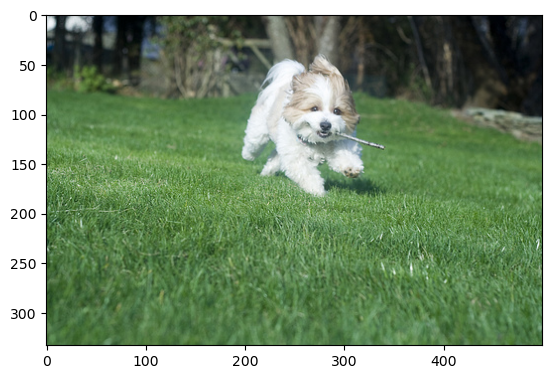

In [97]:
test_model()

328    a tennis player wear a blue shirt raise his hand and smile
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


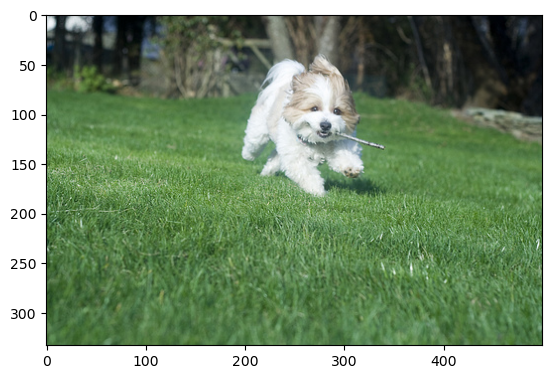

In [98]:
test_model()

254    there be several people watch a person in the air with sky surround by mountain and snow
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


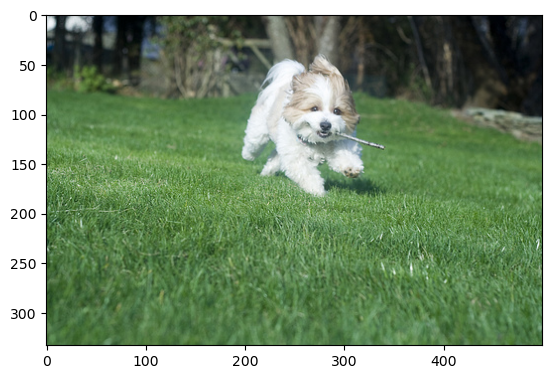

In [99]:
test_model()

35    a brown dog with a black collar stand next to a bush
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


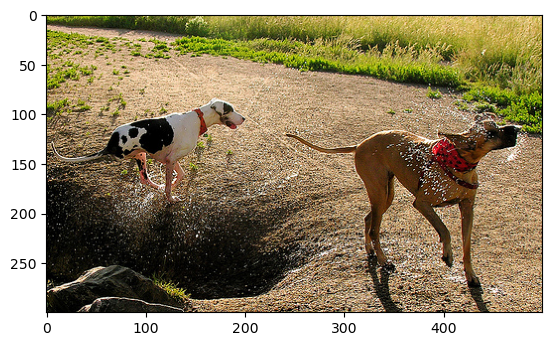

In [100]:
test_model()

38    stretch image of a brown dog with a white patch of fur in his chest area sit in the grass with tree in the background
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


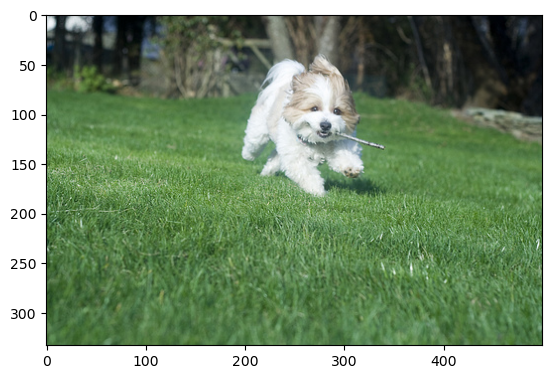

In [101]:
test_model()

258    a man and a woman wear funny mask and pretend to smoke large fake cigar
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


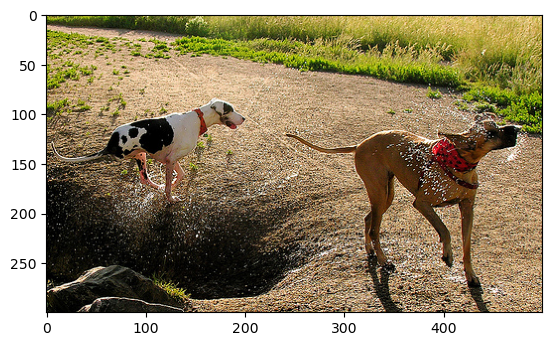

In [102]:
test_model()

426    two small white dog chase after a red ball
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


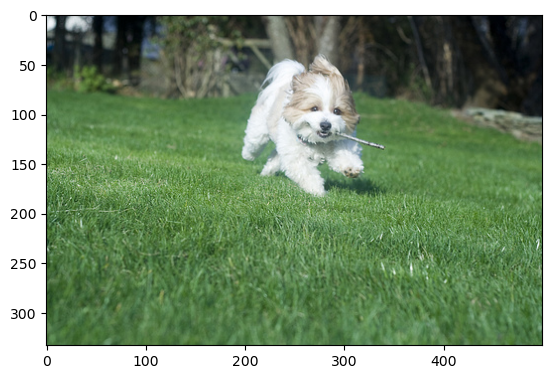

In [103]:
test_model()

461    a small shaggy dog play with a red ball on the grass
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


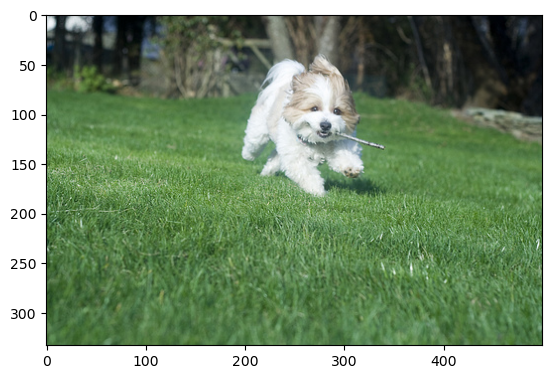

In [104]:
test_model()

In [105]:
test_model()

407    a little girl blow out the candle on her cake
This image is unavailable in your country in compliance with local laws.


303    three men on mountain bike go over a sand hill
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


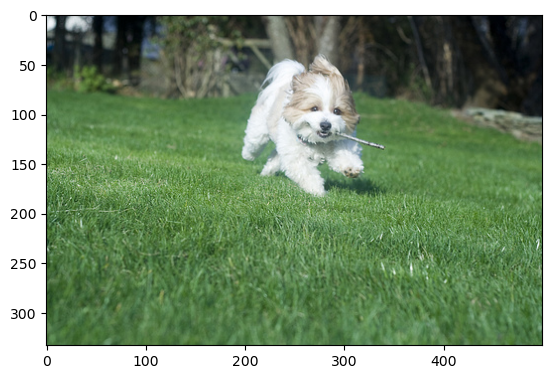

In [106]:
test_model()

## Выводы

Для реализации проекта изображения и текстовые описания были преобразованы в векторы. Затем векторы объединяются друг с другом, а также с целевым значением - вероятность совпадения изображения и текста.
На этих данных были обучены 2 модели - линейная регрессия и нейронная сеть. Последняя показала лучший результат.

В результате тестирования, делаю вывод, что модель не справляется с задачей подбора подходящего изображения по тексту. На мой взгляд, количество представленных данных не может обеспечить какую-либо точность. Требуется гораздо больше данных для обучения. Возможно, стоит использовать другие подходы, например, рассматривать отдельно векторы изображений и текстов и искать между ними ближайшее расстояние.